In [1]:
import glob
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec

In [2]:
# --- FUNCTION to preprocess .txt files for consistent delimiters


def preprocess_txt(file_path):
    data = []  # Initialize a list to store the processed data

    # Initialize a flag to determine if we are reading the header
    is_header = True

    # Read the file line by line and process the data
    with open(file_path) as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if is_header:
                # Split the first line into column names
                column_names = re.split(r"\s+", line)
                is_header = False
            else:
                # Split the other lines into data values
                values = re.split(r"\s+", line)
                data.append(values)

    # Create a DataFrame with the processed data and set column names
    df = pd.DataFrame(data, columns=column_names)
    # return
    return df

In [4]:
# --- read in profile data
# profile data have one file per timestep, so we must read each in separately and combine


# where results are stored
results_path = "example_3-2_site8"  # "example_3-3-15xRadius_site8"
flx_path, prof_path = os.path.join(results_path, "flx"), os.path.join(
    results_path, "prof"
)

# define file name pattern
fn_pref = ["prof_sld(wt%)", "sat_sld", "rate"]
fn_ext = ".txt"

# loop through variables
df = pd.DataFrame()  # initialize empty df to store dat
for var in fn_pref:
    # set pattern
    fn_pattern = f"{var}-*{fn_ext}"
    # get list of filenames
    file_paths = glob.glob(f"{prof_path}/{fn_pattern}")

    # read in data and concatenate
    for file_path in file_paths:
        dfi = preprocess_txt(file_path)
        # apply pd.to_numeric to all columns using the "map" method
        dfi = dfi.map(pd.to_numeric)
        # add var
        dfi["var"] = var
        # combine
        df = pd.concat([df, dfi], ignore_index=True)


# sort by time and depth
df = df.sort_values(by=["var", "time", "z"])
df

,z,amsi,cc,dlm,tm,ka,dp,qtz,ill,cabd,kfs,ab,g2,time,var
180,0.008333,25.234779,3.825255,1.433517e+00,1.770604e+00,2.379563,9.721684e+00,20.382997,7.631922,1.058310,3.589494,14.605712,8.366163,1.127568,prof_sld(wt%)
181,0.025000,27.048546,3.979558,1.807328e+00,1.897930e+00,2.550643,1.042039e+01,21.848079,8.180517,1.134395,3.847491,15.655496,1.629632,1.127568,prof_sld(wt%)
182,0.041667,27.423969,4.006612,1.894915e+00,1.924710e+00,2.585998,1.056501e+01,22.151364,8.294107,1.150153,3.900895,15.872779,0.229493,1.127568,prof_sld(wt%)
183,0.058333,27.477974,4.010244,1.907680e+00,1.929376e+00,2.591047,1.058581e+01,22.195019,8.310480,1.152426,3.908581,15.904027,0.027337,1.127568,prof_sld(wt%)
184,0.075000,27.484448,4.010533,1.909358e+00,1.930079e+00,2.591624,1.058831e+01,22.200278,8.312473,1.152703,3.909506,15.907764,0.002928,1.127568,prof_sld(wt%)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,0.425000,0.188786,0.000731,9.982034e-08,2.533456e-31,16.634346,9.822787e-13,4.638894,0.083335,4.436018,0.093524,0.000102,0.371089,120514.181750,sat_sld
1106,0.441667,0.202826,0.000929,1.624805e-07,2.520727e-30,16.209769,1.848742e-12,4.983884,0.100868,4.929747,0.120241,0.000132,0.371089,120514.181750,sat_sld
1107,0.458333,0.217640,0.001179,2.637180e-07,2.453796e-29,15.735727,3.460368e-12,5.347899,0.121060,5.444057,0.153376,0.000169,0.371089,120514.181750,sat_sld
1108,0.475000,0.233188,0.001624,4.871353e-07,3.521090e-28,15.116304,7.347855e-12,5.729951,0.146498,6.008650,0.197397,0.000219,0.371089,120514.181750,sat_sld


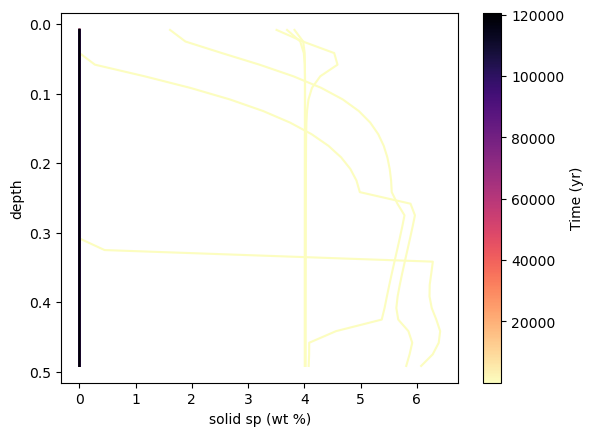

In [5]:
# --- plot depth profile of calcite through time
dfx = df[df["var"] == "prof_sld(wt%)"]
# Group the DataFrame by the 'time' column
grouped = dfx.groupby("time")

# Create a colormap
cmap = plt.get_cmap("magma")  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap
# -- log normalization WIP
# log_time = np.log(df['time'])
# norm = plt.Normalize(log_time.min(), log_time.max())  # Normalize time values for colormap

# Create a plot for each time step
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["cc"], group["z"], color=color, label=None)
    # plt.plot(group['gt'], group['z'], color=color, linestyle='dashed', label=None)

# Add labels and a legend
plt.xlabel("solid sp (wt %)")
plt.ylabel("depth")

# Create a colorbar based on the Viridis colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array for the colorbar data
cbar = plt.colorbar(sm, label="Time (yr)", ax=plt.gca())

# flip y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

KeyError: 'gt'

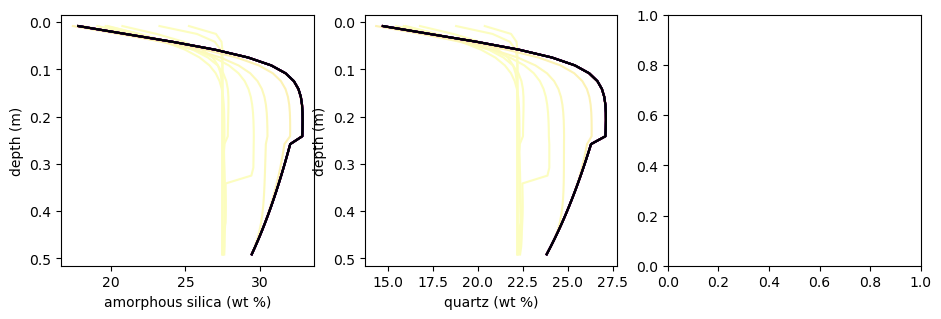

In [6]:
# --- multi-panel plot (pieces of Kanzaki et al., Fig. 8)
dfx = df[df["var"] == "prof_sld(wt%)"]
# Group the DataFrame by the 'time' column
grouped = dfx.groupby("time")

# Create a colormap
cmap = plt.get_cmap("magma")  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap
# -- log normalization WIP
# log_time = np.log(df['time'])
# norm = plt.Normalize(log_time.min(), log_time.max())  # Normalize time values for colormap

# Create a new figure and set up a GridSpec
fig = plt.figure(figsize=(15, 15))  # Adjust figsize as needed
gs = GridSpec(4, 4, figure=fig)


# Create a plot for each time step

# --- ROW 1

# [PANEL 1: AMORPHOUS SILICA]
ax = fig.add_subplot(gs[0, 0])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["amsi"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("amorphous silica (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 2: QUARTZ]
ax = fig.add_subplot(gs[0, 1])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["qtz"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("quartz (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 3: GOETHITE]
ax = fig.add_subplot(gs[0, 2])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["gt"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("goethite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 4: CALCITE]
ax = fig.add_subplot(gs[0, 3])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["cc"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("calcite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()


# --- ROW 2

# [PANEL 5: DOLOMITE]
ax = fig.add_subplot(gs[1, 0])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["dlm"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("dolomite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 6: K-SPAR]
ax = fig.add_subplot(gs[1, 1])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["kfs"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("k-spar (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 7: ALBITE]
ax = fig.add_subplot(gs[1, 2])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["ab"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("albite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 8: ANORTHITE]
ax = fig.add_subplot(gs[1, 3])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["an"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("anorthite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()


# --- ROW 3

# [PANEL 9: DIOPSIDE]
ax = fig.add_subplot(gs[2, 0])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["dp"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("diopside (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 10: TREMOLITE]
ax = fig.add_subplot(gs[2, 1])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["tm"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("tremolite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 11: FORSTERITE]
ax = fig.add_subplot(gs[2, 2])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["fo"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("forsterite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 12: FAYARITE]
ax = fig.add_subplot(gs[2, 3])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["fa"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("fayarite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()


# --- ROW 4

# [PANEL 13: ILLITE]
ax = fig.add_subplot(gs[3, 0])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["ill"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("illite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 14: Ca BEIDELITE]
ax = fig.add_subplot(gs[3, 1])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["cabd"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("ca beidelite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 15: Kaolinite]
ax = fig.add_subplot(gs[3, 2])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["ka"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("kaolinite (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# [PANEL 16: SOM Class 2]
ax = fig.add_subplot(gs[3, 3])
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["g2"], group["z"], color=color, label=None)
# Add labels and a legend
plt.xlabel("SOM Class 2 (wt %)")
plt.ylabel("depth (m)")
# flip y-axis
plt.gca().invert_yaxis()

# Create a colorbar based on the Viridis colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array for the colorbar data
cbar = plt.colorbar(sm, label="Time (yr)", ax=plt.gca())


# Show the plot
plt.show()

KeyError: 'py'

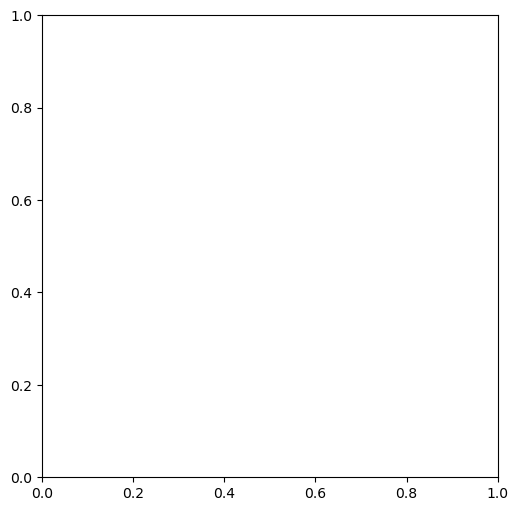

In [6]:
# --- multi-panel plot for all vars
# define number of rows and cols based on unique vars
unique_vars = df["var"].unique()
num_cols = 3
num_rows = (len(unique_vars) + num_cols - 1) // num_cols

# Create a new figure and set up a GridSpec
fig = plt.figure(figsize=(20, 6))  # Adjust figsize as needed
gs = GridSpec(num_rows, num_cols, figure=fig)

for i, var in enumerate(unique_vars):
    # get the row and column indices for the current subplot
    row = i // num_cols
    col = i % num_cols

    # Create a subplot within the GridSpec
    ax = fig.add_subplot(gs[row, col])

    # Filter the DataFrame for the current var
    var_df = df[df["var"] == var]

    # Group the DataFrame by the 'time' column
    grouped = var_df.groupby("time")

    # Create a colormap
    cmap = plt.get_cmap("magma")  # Get the colormap
    cmap = cmap.reversed()  # flip colormap
    # -- no log normalization
    norm = plt.Normalize(
        var_df["time"].min(), var_df["time"].max()
    )  # Normalize time values for colormap
    # -- log normalization WIP
    # log_time = np.log(df['time'])
    # norm = plt.Normalize(log_time.min(), log_time.max())  # Normalize time values for colormap

    # Create a plot for each time step
    for time, group in grouped:
        color = cmap(norm(time))  # Map time to color using Viridis colormap
        ax.plot(group["py"], group["z"], color=color, label=None)
        ax.plot(group["gt"], group["z"], color=color, linestyle="dashed", label=None)
        ax.plot(
            group["fe2o2"], group["z"], color=color, linestyle="dashdot", label=None
        )

    # Add labels and a legend
    ax.set_xlabel(var)
    ax.set_ylabel("depth")

    # Create a colorbar based on the Viridis colormap
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])  # Set an empty array for the colorbar data
    # cbar = plt.colorbar(sm, label='Time (s)', ax=plt.gca())

    # Add a legend to the last subplot
    if i == len(unique_vars) - 1:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Set an empty array for the colorbar data
        cbar = plt.colorbar(sm, label="Time (yr)", ax=plt.gca())

    # flip y-axis
    plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()